In [47]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms.community.centrality import girvan_newman
from networkx.algorithms.community import k_clique_communities
import networkx.algorithms.community as nx_comm
from sklearn.cluster import SpectralClustering
from sklearn import metrics
import itertools
import numpy as np
import infomap
from infomap import Infomap
from sklearn.metrics.cluster import mutual_info_score
from utils import *

# LFR Graph community detection. 
#####  Import LFR benchmark network “Benchmark graphs for testing community detection algorithms”, Andrea Lancichinetti, Santo Fortunato, and Filippo Radicchi, Phys. Rev. E 78, 046110 2008


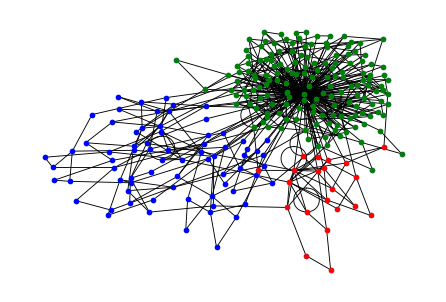

The ground truth modularity is 0.376


In [2]:
n = 250 # Number of nodes in the created graph.
tau1 = 3 # Power law exponent for the degree distribution of the created graph. 
tau2 = 1.5 # Power law exponent for the community size distribution in the created graph.
mu = 0.1 # Fraction of inter-community edges incident to each node. 

G = nx.LFR_benchmark_graph( n, tau1, tau2, mu, average_degree=5, min_community=20, seed=10) 
# Get ground truth communities
ground_truth_communities = list({frozenset(G.nodes[v]["community"]) for v in G})
presentCommunities(G,ground_truth_communities)
# Use modularity to check partition
ground_truth_mod = nx_comm.modularity(G,ground_truth_communities)
print(f"The ground truth modularity is {ground_truth_mod:.3}")

# Girvan Newman 
##### Invesitigate how modularity changes as more disconections are made and more communities are found

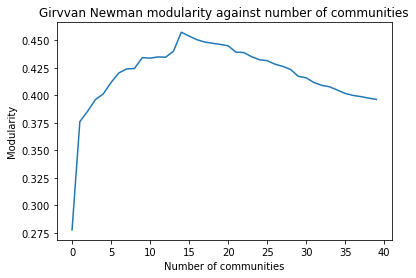

CPU times: user 14.4 s, sys: 54.2 ms, total: 14.4 s
Wall time: 14.3 s


In [3]:
%%time
# Algorithm 1. Girvan Newman 
partition_girvan_newman = girvan_newman(G)
k = 40 # Check 39 partitions

mod_list = []
for communities in itertools.islice(partition_girvan_newman, k):
    partitions = tuple(sorted(c) for c in communities)
    # Use modularity to check partition
    GN_mod = nx_comm.modularity(G,partitions)
    mod_list.append(GN_mod)

# plot partitions with k to optimize modularity
plt.plot(mod_list)
plt.xlabel("Number of communities")
plt.ylabel("Modularity")
plt.title("Girvvan Newman modularity against number of communities")
plt.show()

##### Check modularity with apriori knowledge of 3 communities from the ground truth

3 communities detected
The modularity is 0.376


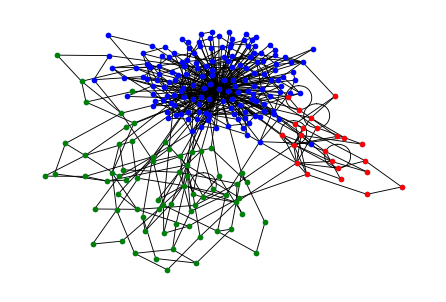

CPU times: user 5.37 s, sys: 75.9 ms, total: 5.44 s
Wall time: 5.3 s


In [4]:
%%time 
partition_girvan_newman = girvan_newman(G)
k=2 # if we have apriori knowledge of 3 groudn truth communities:
for communities in itertools.islice(partition_girvan_newman, k):
    GN_partitions = tuple(sorted(c) for c in communities)


GN_mod = nx_comm.modularity(G,GN_partitions)
print(f"{len(GN_partitions)} communities detected")
print(f"The modularity is {GN_mod:.3}")
presentCommunities(G,GN_partitions)

# Infomap
#####  https://github.com/mapequation/infomap

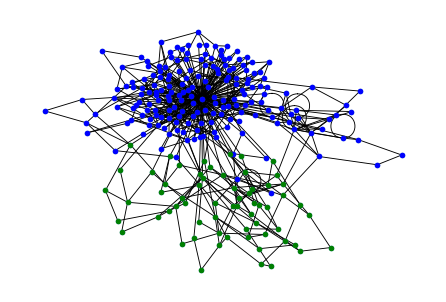

2 communities detected
The modularity is 0.26
CPU times: user 419 ms, sys: 64.4 ms, total: 483 ms
Wall time: 190 ms


In [5]:
%%time
# Algorithm 2. k infomap

im = Infomap(silent=True)
im.add_networkx_graph(G)
im.run()

infomap_partition = [[] for _ in range(im.num_top_modules)]
for node in im.tree:
    if node.is_leaf:
        infomap_partition[node.module_id-1].append(node.node_id)

# Need to decide when to stop removing edges.
presentCommunities(G,infomap_partition)

info_mod = nx_comm.modularity(G,tuple(infomap_partition))
print(f"{len(infomap_partition)} communities detected")
print(f"The modularity is {info_mod:.3}")

# Spectral Clustering

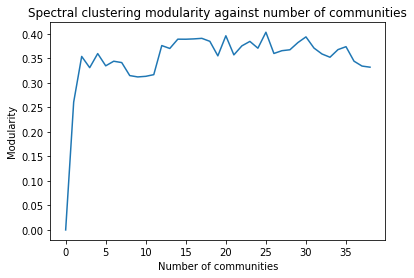

CPU times: user 1min 17s, sys: 50.6 s, total: 2min 8s
Wall time: 27.3 s


In [6]:
%%time
# Algorithm 3. Spectral clustering

# Get adjacency-matrix as numpy-array
sc_mod_list = []
for k in range(1,40):
    adj_mat = nx.to_numpy_matrix(G)
    # Cluster
    sc = SpectralClustering(k, affinity='precomputed', n_init=100)
    sc.fit(adj_mat)

    partition_labels = sc.labels_.tolist()
    # Turn back into partition data structure ([],[],[]...)
    # position in list is node number value is community id

    partition = [[] for _ in range(max(partition_labels)+1)]
    for idx,c in enumerate(partition_labels):
        partition[c].append(idx)

    sc_mod = nx_comm.modularity(G,tuple(partition))
    sc_mod_list.append(sc_mod)

# Plot modularity for increasing community number
plt.plot(sc_mod_list)
plt.xlabel("Number of communities")
plt.ylabel("Modularity")
plt.title("Spectral clustering modularity against number of communities")
plt.show()

##### With apriori knowledge of ground truth community number k = 3

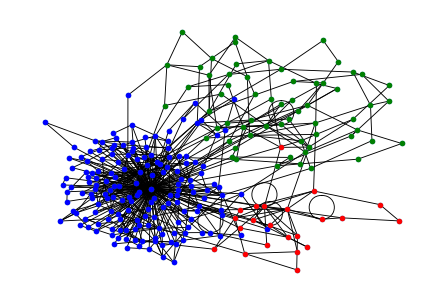

3 communities detected
The modularity is 0.354
CPU times: user 715 ms, sys: 306 ms, total: 1.02 s
Wall time: 345 ms


In [7]:
%%time
k=3
# Get adjacency-matrix as numpy-array
adj_mat = nx.to_numpy_matrix(G)
# Cluster
sc = SpectralClustering(k, affinity='precomputed', n_init=100)
sc.fit(adj_mat)

partition_labels = sc.labels_.tolist()
# Turn back into partition data structure ([],[],[]...)
# position in list is node number value is community id

sc_partition = [[] for _ in range(max(partition_labels)+1)]
for idx,c in enumerate(partition_labels):
    sc_partition[c].append(idx)

# Need to decide when to stop removing edges.
presentCommunities(G,sc_partition)

sc_mod = nx_comm.modularity(G,tuple(sc_partition))
print(f"{len(sc_partition)} communities detected")
print(f"The modularity is {sc_mod:.3}")

# Analysis

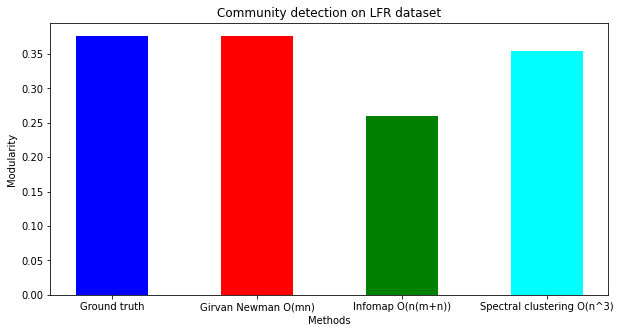

In [8]:
# Compare methods
data = {'Ground truth':ground_truth_mod, 'Girvan Newman O(mn)':GN_mod, 'Infomap O(n(m+n))':info_mod,
        'Spectral clustering O(n^3)':sc_mod}
method = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(method, values,
        width = 0.5, color=['blue', 'red', 'green', 'cyan'])
 
plt.xlabel("Methods")
plt.ylabel("Modularity")
plt.title("Community detection on LFR dataset")
plt.show()

In [48]:


# normalized_mutual_info_score(community_a, community_b)

# (ground_truth_communities)
# (infomap_partition) # cannot compare its communities as only two found
# (sc_partition)
# (GN_partitions)

# compare the clustering
# Appriximate which clusters have the most overlap with the ground truth.
for ground_truth_community in ground_truth_communities:
    for GN_partition in GN_partitions:

        if len(list(ground_truth_community)) < len(GN_partition):
            print(mutual_info_score(GN_partition[0:len(ground_truth_community)], list(ground_truth_community)))
        else:
            print(mutual_info_score(GN_partition, list(ground_truth_community)[0:len(GN_partition)]))




4.276666119016054
4.2484952420493585
3.1354942159291497
5.056245805348309
4.2484952420493585
3.1354942159291497
3.044522437723422
3.044522437723422
3.044522437723422
